https://www.tensorflow.org/tutorials/keras/basic_classification

https://github.com/Zackory/Keras-MNIST-GAN/blob/master/mnist_gan.py


In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

K.set_image_dim_ordering('th')

from keras.layers.advanced_activations import LeakyReLU

Using TensorFlow backend.


In [2]:
fashion_mnist = keras.datasets.fashion_mnist

In [3]:
(tr_im,tr_lab),(tt_im,tt_lab) = fashion_mnist.load_data()

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [5]:
tr_im.shape

(60000, 28, 28)

In [6]:
tr_lab

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

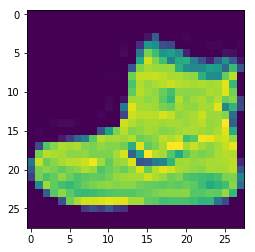

In [7]:
plt.imshow(tr_im[0,:,:])

In [8]:
npar = 100 #number of standard normal deviates to feed to generator input

In [9]:
tr_im.max()

255

In [10]:
tr_im = tr_im / tr_im.max()
tr_im = tr_im.reshape(tr_im.shape[0],784)

In [11]:
tt_im = tt_im / tt_im.max()
tt_im = tt_im.reshape(tt_im.shape[0],784)

In [18]:
#opt = tf.train.AdamOptimizer(learning_rate=0.0005,beta1=0.5)
opt = Adam(lr=0.0005,beta_1=0.5)

In [14]:
# generator = keras.Sequential()
# generator.add(keras.layers.Dense(256, input_dim=npar, kernel_initializer=keras.initializers.RandomNormal(stddev=0.02)))
# generator.add(keras.layers.LeakyReLU(0.2))
# generator.add(keras.layers.Dense(512))
# generator.add(keras.layers.LeakyReLU(0.2))
# generator.add(keras.layers.Dense(1024))
# generator.add(keras.layers.LeakyReLU(0.2))
# generator.add(keras.layers.Dense(784, activation="sigmoid"))
# generator.compile(loss='binary_crossentropy', optimizer=opt)
# generator.summary()

In [ ]:
# discriminator = keras.Sequential()
# discriminator.add(keras.layers.Reshape((28,28,1),input_shape=(784,)))
# discriminator.add(keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding="same")
# discriminator.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",activation=tf.nn.relu))
# discriminator.add(keras.layers.MaxPool2D(pool_size=(2,2)))
# discriminator.add(keras.layers.Dropout(0.25))
# discriminator.add(keras.layers.Flatten())
# discriminator.add(keras.layers.Dense(128,activation=tf.nn.relu))
# discriminator.add(keras.layers.Dropout(0.5))
# discriminator.add(keras.layers.Dense(1,activation="sigmoid"))

# discriminator.summary()
# discriminator = keras.Sequential()
# discriminator.add(keras.layers.Dense(1024, input_dim=784, kernel_initializer=keras.initializers.RandomNormal(stddev=0.02)))
# discriminator.add(keras.layers.LeakyReLU(0.2))
# discriminator.add(keras.layers.Dropout(0.3))
# discriminator.add(keras.layers.Dense(512))
# discriminator.add(keras.layers.LeakyReLU(0.2))
# discriminator.add(keras.layers.Dropout(0.3))
# discriminator.add(keras.layers.Dense(256))
# discriminator.add(keras.layers.LeakyReLU(0.2))
# discriminator.add(keras.layers.Dropout(0.3))
# discriminator.add(keras.layers.Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=opt)
discriminator.summary()

In [19]:
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=npar, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((128, 7, 7)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=opt)

# Discriminator
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(1, 28, 28), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=opt)

In [38]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 128, 7, 7)         0         
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 128, 14, 14)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 14, 14)        204864    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 64, 14, 14)        0         
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, 64, 28, 28)        0         
__________

In [39]:
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 64, 14, 14)        1664      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 64, 14, 14)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 14, 14)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 7, 7)         204928    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 128, 7, 7)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 7, 7)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
__________

/Users/jeremyw/miniconda3/envs/py36/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [24]:
discriminator.trainable = False
gi = Input(shape=(npar,))
x = generator(gi)
go = discriminator(x)
gan = Model(inputs=gi,outputs=go)
gan.compile(loss="binary_crossentropy",optimizer=opt)

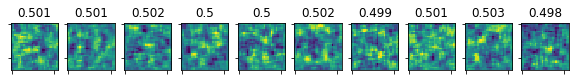

In [25]:

def plot_gen():
    fig, axes = plt.subplots(nrows=1,ncols=10,figsize = (10,10))
    plot_noise = np.random.randn(10,npar) 
    vecs = generator.predict(plot_noise)#.reshape(10,28,28)
    isreal = discriminator.predict(vecs)
    #print(isreal.shape)
    for ax,vec,real in zip(axes.flatten(),vecs.reshape(10,28,28),isreal.flatten()):
        ax.imshow(vec)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title("{0:1.3G}".format(real))
plot_gen()
#generator.save("test.h5")
o_d = "gen_models"
if os.path.exists(o_d):
    shutil.rmtree(o_d)
os.mkdir(o_d)

468


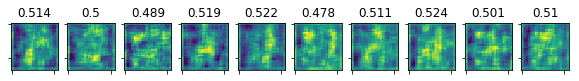

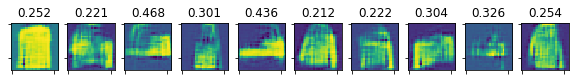

KeyboardInterrupt: 

In [37]:
batch_size = 128
batch_count = int(tr_im.shape[0] / batch_size)
print(batch_count)
plot_gen()
plt.show()
for e in range(1,400):
    for _ in range(batch_count):
        noise = np.random.randn(batch_size,npar)
        tr_im_batch = tr_im[np.random.randint(0,tr_im.shape[0],size=batch_size)]
        gen_im = generator.predict(noise)
        tr_im_batch = np.resize(tr_im_batch,(batch_size,1,28,28))
        #print(gen_im.shape,tr_im_batch.shape)
        tr_im_batch = np.concatenate([tr_im_batch,gen_im])
        #noisy labels...
        tr_im_lab = np.zeros(tr_im_batch.shape[0])
        tr_im_lab[:batch_size] = np.random.uniform(0.9,1.0,size=batch_size)
        tr_im_lab[batch_size:] = np.random.uniform(0.0,0.1,size=batch_size)
        discriminator.trainable = True
        dloss = discriminator.train_on_batch(tr_im_batch,tr_im_lab)
        noise = np.random.randn(batch_size,npar)
        tr_img_lab = np.ones(batch_size)
        discriminator.trainable = False
        gloss = gan.train_on_batch(noise,tr_img_lab)
        print(gloss,dloss,end="\r")
    if e % 1 == 0:
        #print(e,dloss,gloss)
        plot_gen()
        plt.show()
        generator.save(os.path.join(o_d,"gen_{0}.h5").format(e))
        
    